In [4]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Dummy Dataset
np.random.seed(42)
n = 2000

age = np.random.randint(21, 70, size=n)
income = np.round(np.random.normal(60000, 25000, size=n)).clip(8000, 300000)
loan_amount = np.round(np.random.normal(15000, 10000, size=n)).clip(1000, 100000)
loan_term_month = np.random.choice([12, 24, 36, 48, 60], size=n, p=[0.05, 0.15, 0.4, 0.25, 0.15])
credit_score = np.round(np.random.normal(650, 70, size=n)).clip(300, 850)
employment_years = np.round(np.random.exponential(scale=3, size=n)).astype(int)
prior_defaults = np.random.choice([0, 1], size=n, p=[0.9, 0.1])
marital_status = np.random.choice(['single', 'married', 'divorced', 'widowed'], size=n, p=[0.45, 0.45, 0.07, 0.03])
purpose = np.random.choice(['debt_consolidation', 'home_improvement', 'education', 'car', 'other'],
                           size=n, p=[0.5, 0.15, 0.1, 0.15, 0.1])

# probability of default formula
loan_income_ratio = loan_amount / (income + 1)
score = (
    -3.0 * (credit_score - 650) / 100.0
    + 6.0 * loan_income_ratio
    - 0.2 * employment_years
    + 2.5 * prior_defaults
    + np.where(purpose == 'debt_consolidation', 0.5, 0.0)  # <-- Fixed typo
    + np.where(marital_status == 'single', 0.1, 0.0)
)
prob_default = 1 / (1 + np.exp(-score))
default = (np.random.rand(n) < prob_default).astype(int)

# Create DataFrame
df = pd.DataFrame({
    'age': age,
    'income': income,
    'loan_amount': loan_amount,
    'loan_term_month': loan_term_month,  # <-- Added missing column
    'credit_score': credit_score,
    'employment_years': employment_years,
    'marital_status': marital_status,
    'purpose': purpose,
    'default': default
})

print("Dataset Created Successfully")
print(df.head())
df.info()
# Data Preprocessing
X = df.drop(columns=['default'])
y = df['default']

# Encode categorical variables
X = pd.get_dummies(X, columns=['marital_status', 'purpose'], drop_first=True)

# Split dataset
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# Scale numeric columns
nums_cols = ['age', 'income', 'loan_amount', 'loan_term_month', 'credit_score', 'employment_years']
scaler = StandardScaler()
x_train[nums_cols] = scaler.fit_transform(x_train[nums_cols])
x_test[nums_cols] = scaler.transform(x_test[nums_cols])

#Train model
lr = LogisticRegression (max_iter = 1000, solver = 'liblinear')
rf = RandomForestClassifier(n_estimators = 200, random_state = 42, n_jobs = -1)
lr.fit(x_train,y_train)
rf.fit(x_train,y_train)

# Evaluate model

models = {'Logistic Regression':lr,'Random Forest':rf}
results = {}

for name,model in models.items():
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)[:,1]
    auc = roc_auc_score(y_test,y_prob)
    report = classification_report(y_test , y_pred)
    cm = confusion_matrix(y_test , y_pred)
    results[name] = {'auc':auc,'report':report,'cm':cm}
    print(f"\n== {name} ==")
    print(f"ROC AUC:{auc:.4f}")
    print(report)
    print("Confusion Matrix:\n",cm)

Dataset Created Successfully
   age    income  loan_amount  loan_term_month  credit_score  \
0   59  119214.0       7796.0               36         709.0   
1   49   49399.0       7377.0               60         607.0   
2   35   51164.0      30502.0               36         549.0   
3   63    9333.0      15697.0               36         577.0   
4   28   74280.0      15762.0               48         662.0   

   employment_years marital_status             purpose  default  
0                 2       divorced  debt_consolidation        0  
1                10        married  debt_consolidation        0  
2                 0       divorced  debt_consolidation        1  
3                 3        married  debt_consolidation        1  
4                 6        married  debt_consolidation        0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------

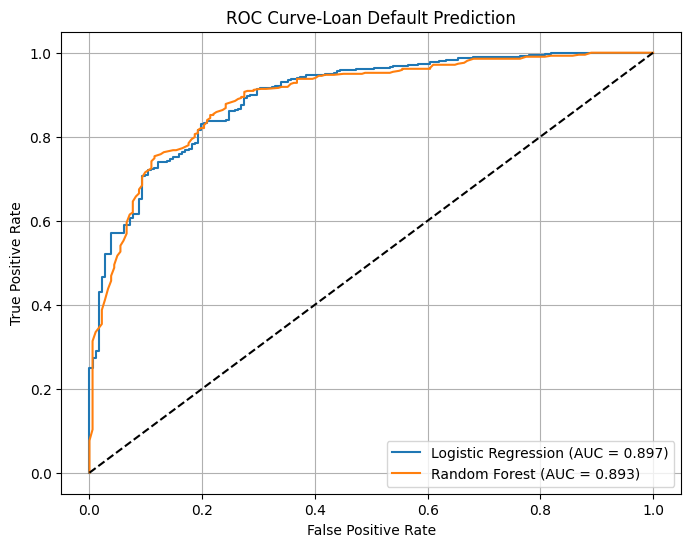

In [5]:
# plot Roc Curve
plt.figure(figsize = (8,6))
for name,model in models.items():
    y_prob = model.predict_proba(x_test)[:,1]
    fpr,tpr, _ = roc_curve(y_test,y_prob)
    auc = roc_auc_score(y_test,y_prob)
    plt.plot(fpr,tpr,label = f"{name} (AUC = {auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve-Loan Default Prediction')
plt.legend()
plt.grid(True)
plt.show()

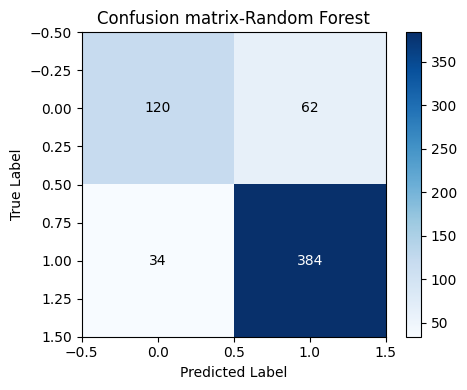

In [6]:
# confusion matrix(random forest)
cm = results['Random Forest']['cm']
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
plt.title('Confusion matrix-Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.colorbar()

for i in range (cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j,i,format(cm[i,j]),
        ha = "center", va = "center",
        color = "white" if cm[i,j] > cm.max()/2 else "black")
plt.tight_layout()
plt.show()

# Graphicall representation

# Pie plot

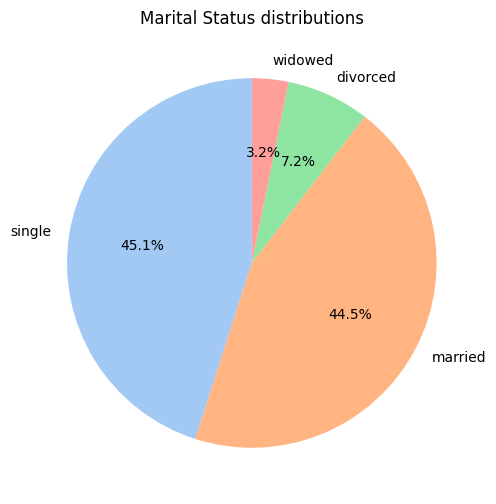

In [7]:
plt.figure(figsize=(6,6))
df["marital_status"].value_counts().plot.pie(autopct='%1.1f%%',startangle=90,colors=sns.color_palette('pastel'))
plt.title('Marital Status distributions')
plt.ylabel('')
plt.show()

# Bar chart

C:\Users\dell\AppData\Local\Temp\ipykernel_18300\1513668791.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='purpose',data=df,palette='Set2')
C:\Users\dell\AppData\Local\Temp\ipykernel_18300\1513668791.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


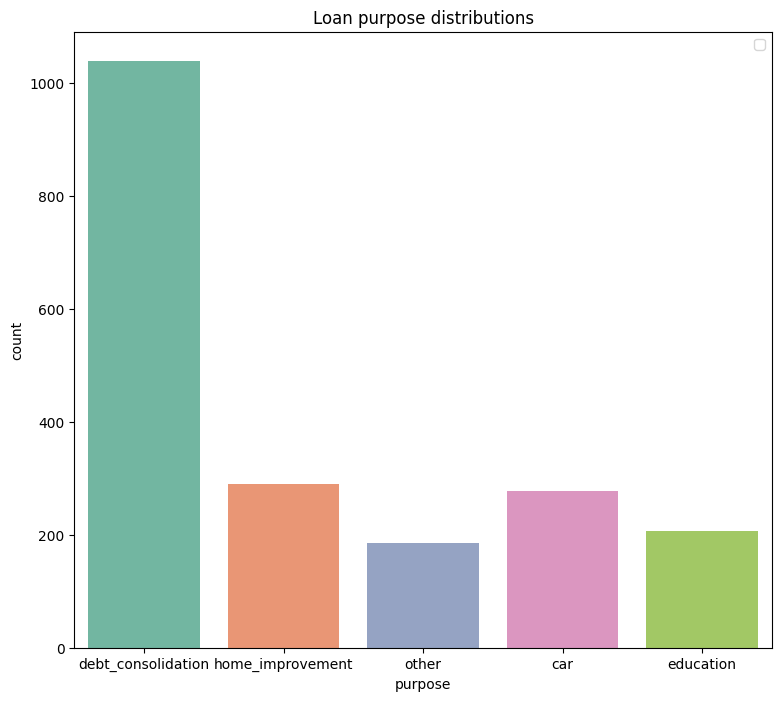

In [8]:
plt.figure(figsize=(9,8))
sns.countplot(x='purpose',data=df,palette='Set2')
plt.title('Loan purpose distributions')
plt.xlabel('purpose')
plt.ylabel('count')
plt.legend()
plt.show()

# Line plot

C:\Users\dell\AppData\Local\Temp\ipykernel_18300\4083866654.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='purpose', y='loan_amount', data=df, palette='cool')


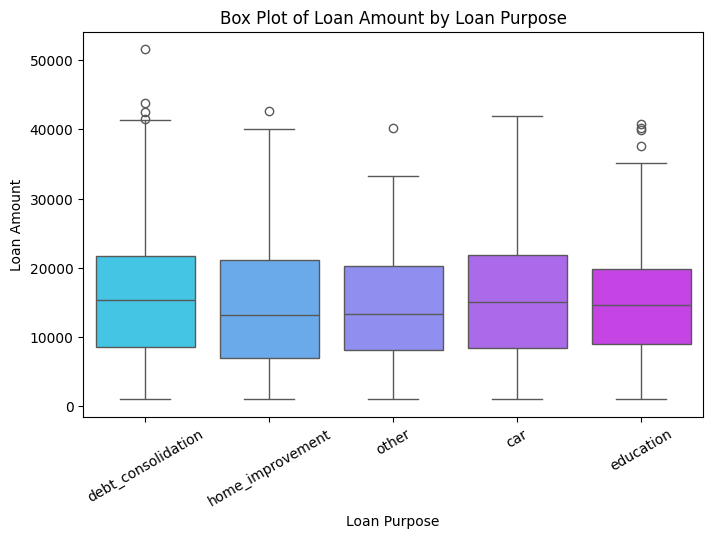

In [9]:
plt.figure(figsize=(8,5))
sns.boxplot(x='purpose', y='loan_amount', data=df, palette='cool')
plt.title("Box Plot of Loan Amount by Loan Purpose")
plt.xlabel("Loan Purpose")
plt.ylabel("Loan Amount")
plt.xticks(rotation=30)
plt.show()

# 3D Scatter Ploting

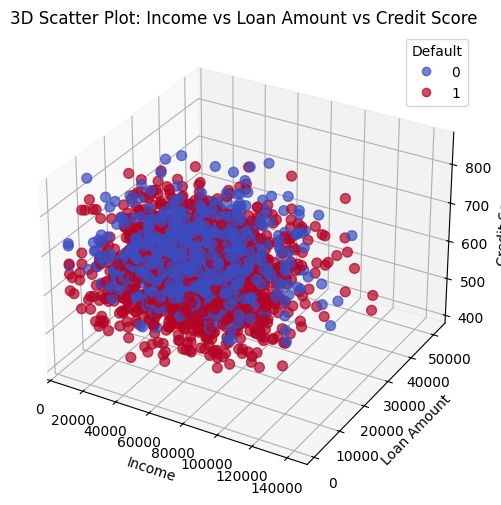

In [12]:
#3D Scatter plot loan amount and loan purpose

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df['income'],
    df['loan_amount'],
    df['credit_score'],
    c=df['default'],  # color by default status (0 or 1)
    cmap='coolwarm',
    s=50,
    alpha=0.7
)

ax.set_xlabel('Income')
ax.set_ylabel('Loan Amount')
ax.set_zlabel('Credit Score')
ax.set_title('3D Scatter Plot: Income vs Loan Amount vs Credit Score')
plt.legend(*scatter.legend_elements(), title="Default", loc="upper right")
plt.show()

# Histogram Ploting

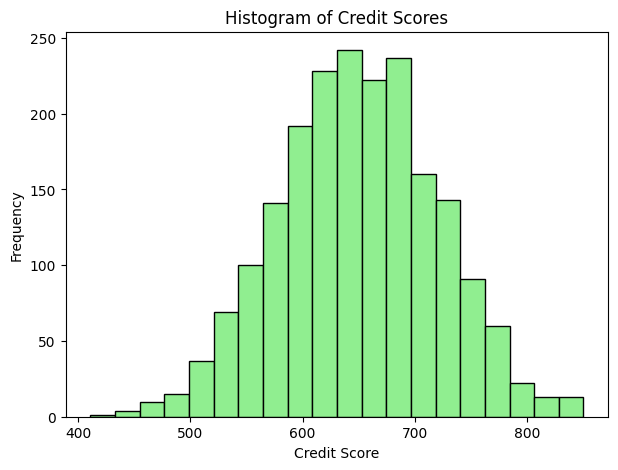

In [13]:
# Hist plot
plt.figure(figsize=(7,5))
plt.hist(df['credit_score'], bins=20, color='lightgreen', edgecolor='black')
plt.title("Histogram of Credit Scores")
plt.xlabel("Credit Score")
plt.ylabel("Frequency")
plt.show()